# FIXME

1. [x] Clean up the file
  - [x] Clean up the imports
  - [x] Clean up the helper functions - ultimately these should use the libraries
  - [x] Clean up the plots
2. [ ] Figure out how to serialize the rationals that we identify
  - [ ] Write the serialization logic
  - [ ] Write the deserialization logic
  - [ ] Serialize the range within the serialization format so that we don't 
proivde bond percentages that are large enough to cause an NaN situation.
3. [ ] Ensure that our approximation never overshoots. This is currently a problem, which will given inaccurate results.
  - [ ] We can accomplish this by subtracting out the worst case positive error.
  - [ ] Compute error rates for this.
  - [ ] Since the error is always at the initial spike, try to create an objective function with an if-statement gated by something like `if x > p1 and x < p2:` where we subtract out the max error to avoid needing to do it everywhere.
4. [ ] Figure out exactly which variables need to be swept over
  - [ ] The required variables are apr, time, and the percent of the bond ratio.
  - [ ] Are share price and initial share price essential? What we can do is start without them and see how bad the approximation is with non-trivial values.
5. [ ] Write the sweeping logic and sanity check it
6. [ ] Write the naive interpolation logic
7. [ ] We can further improve the approximations by first looking for the maximum bond percentage (up to a certain tolerance) that will lead to a NaN value using the bisection method. Then we wouldn't need to filter for NaNs, we'd have a better sampling space for Chebyshev nodes, and we'd avoid 
8. [ ] Write up an explanation for why all of the bonds can't be shorted with non-trivial time stretches.


# Methods

We desire an approximation for the maximum amount of bonds that a trader can short given the ratio of their cash balance to the AMMs cash reserve. To do this, we can calculate the maximum loss for short positions opened with a range of APRs, time remaining, and ratios of bonds to the total bond reserves. For a fixed APR and time remaining, we'll have an array of the maximum loss and the bond ratios shorted. We can find an approximation that tightly fits these points, which is a function of a max loss in base that outputs the ratio of bonds required to hit the max loss.

## TODO - Add detail about the interpolation.

In [121]:
import dill
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy

In [122]:
def calc_time_stretch(apr):
    """Returns fixed time-stretch value based on current apr (as a decimal)"""
    apr_percent = apr * 100
    return 3.09396 / (0.02789 * apr_percent)

def stretch_time(time, time_stretch=1.0):
    """Returns stretched time values"""
    return time / time_stretch

def calc_spot_price_from_reserves(share_reserves, bond_reserves, init_share_price, tau):
    """Calculate the AMM's spot price from the reserves"""
    return ((init_share_price * share_reserves) / bond_reserves) ** tau 

def calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, tau):
    """Returns the 'k' constant variable for trade mathematics"""
    scale = share_price / init_share_price
    return scale * (init_share_price * share_reserves) ** (1 - tau) + (bond_reserves) ** (
        1 - tau
    )

def calc_bond_reserves(share_reserves, apr, share_price, init_share_price, t, tau):
    """Calculates the bond reserves from the share reserves and a target apr"""
    return (init_share_price * share_reserves) * (1 + apr * t) ** (1 / tau)

def calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, fee_percent, tau):
    """Calculates the maximum loss on a short position on the AMM"""
    k = calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, tau)
    d_shares_without_fee = share_reserves - (1 / init_share_price) * ((init_share_price / share_price) * (k - (bond_reserves + d_bonds) ** (1 - tau))) ** (1 / (1 - tau))
    fee = (1 - calc_spot_price_from_reserves(share_reserves, bond_reserves, init_share_price, tau)) * fee_percent * d_bonds
    d_shares = d_shares_without_fee + fee
    return d_bonds - d_shares

def calc_max_loss_from_apr(share_reserves, bond_percentage, apr, share_price, init_share_price, fee_percent, t, tau):
    """Calculates the maximum loss on a short position of a specified percentage of the total bond reserves"""
    bond_reserves = calc_bond_reserves(share_reserves, apr, share_price, init_share_price, t, tau)
    d_bonds = bond_reserves * bond_percentage
    return calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, fee_percent, tau)

def calc_max_loss_endpoints(share_reserves, apr, share_price, init_share_price, fee_percent, t, tau):
    """Find the maximum bond percentage that doesn't cause a max loss of NaN using the bisection method"""
    last_valid_max_loss_percentage = 0
    last_valid_bond_percentage = 0
    bond_percentage = 1
    max_loss = calc_max_loss_from_apr(share_reserves, bond_percentage, apr, share_price, init_share_price, fee_percent, t, tau)
    if not (isinstance(max_loss, complex) or np.isnan(max_loss)):
        return ((max_loss / z) * 100, bond_percentage * 100)
    for step_size in [1 / (2 ** (x + 1)) for x in range(0, 25)]:
        if isinstance(max_loss, complex) or np.isnan(max_loss):
            bond_percentage -= step_size
        else:
            last_valid_max_loss_percentage = (max_loss / z) * 100
            last_valid_bond_percentage = bond_percentage * 100
            bond_percentage += step_size
        max_loss = calc_max_loss_from_apr(share_reserves, bond_percentage, apr, share_price, init_share_price, fee_percent, t, tau)
    return (last_valid_max_loss_percentage, last_valid_bond_percentage)

In [123]:
# FIMXE: Comment this
def calc_chebyshev_nodes(start, end, num_points):
    i = np.delete(np.arange(num_points + 1), 0)
    return ((start + end) / 2) + ((end - start) / 2) * np.cos(((2 * i) / (2 * num_points)) * np.pi)

# FIXME: Comment this
def interpolate_polynomial(xp, yp, num_parameters):
    a = np.vander(xp, num_parameters, True)
    params = np.linalg.solve(a, yp)
    return np.polynomial.Polynomial(params)

# FIXME: Implmenet Remez's algorithm for polynomials

# FIXME: Implement rational interpolation

# FIXME: Implement Remez's algorithm for rationals

def ratobj(num_degree):
    """
    Returns generic n-th degree rational objective function that can be used with 
    SciPy's `curvefit` function to approximate a set of data points.
    """
    return lambda x, *coeffs: np.polyval(coeffs[:num_degree], x) / (1 + np.polyval(coeffs[num_degree:], x) * x)
    
def ratfit(xdata, ydata, xtest, ytest, start_degree=2, end_degree=10, verbose=False):
    """
    Finds the rational polynomial that minimizes the maximum error up to the given degree
    """
    min_error = float("inf")
    min_num_degree = 1
    min_popt = np.ones(1)
    # Compute the least squares optimal rational polynomial over all of the possible degrees
    for degree in range(start_degree, end_degree + 1):
        for div_degree in range(0, degree):
            num_degree = degree - div_degree
            try: 
                # Compute the optimal parameters
                p0 = tuple(np.ones(degree))
                popt, _ = scipy.optimize.curve_fit(ratobj(num_degree), xdata, ydata, p0=p0)
                # Compute the error and the maximum error with the objective function
                error = ytest - ratobj(num_degree)(xtest, *popt)
                error = max(np.amax(error), np.abs(np.amin(error)))
                if verbose: 
                    print(f"num_degree = {num_degree} & div_degree = {div_degree}")
                    print(f"error = {error} & min_error = {min_error}")
                if error < min_error:
                    if verbose:
                        print(f"updated best fit")
                    min_error = error
                    min_num_degree = num_degree
                    min_popt = popt
            except RuntimeError as e:
                if verbose:
                    print(f"ratfit: curve fitting failed for ({num_degree}, {div_degree}) rational with: {e}")
    return (min_num_degree, min_popt)

In [124]:
# FIXME: We may not need to sweep over c, mu, and z.
# Simulation Variables
c = 1                              # share price
mu = 1                             # init share price
z = 10**6                          # share reserves -- this is arbitrary for this analysis
apr = 0.02                         # apr
t = 0.5                            # unstretched time
t_stretch = calc_time_stretch(apr) # time stretch
tau = stretch_time(t, t_stretch)   # stretched time
phi = 0.1                          # fee percent
y_percent = 0.1                    # percent of bond reserves to be shorted

# Other Variables
verbose = False
curves_path = "./max_loss_curves.pkl"

In [125]:
# Calculate the maximum bond percentage that doesn't result in an invalid max loss.
(max_max_loss_percentage, max_bond_percentage) = calc_max_loss_endpoints(z, apr, c, mu, phi, t, tau)
 
# Capture an array of max losses (the x component) and the bond ratios (the y component) 
# that require the max losses.
y = calc_chebyshev_nodes(0, max_bond_percentage, 100)
x = (calc_max_loss_from_apr(z, 0.01 * y, apr, c, mu, phi, t, tau) / z) * 100

# Construct a new trace of sample data to test for the error
y_test = np.delete(np.arange(0, max_bond_percentage, 0.001), 0)
x_test = (calc_max_loss_from_apr(z, 0.01 * y_test, apr, c, mu, phi, t, tau) / z) * 100

Text(0, 0.5, 'Bond Percent')

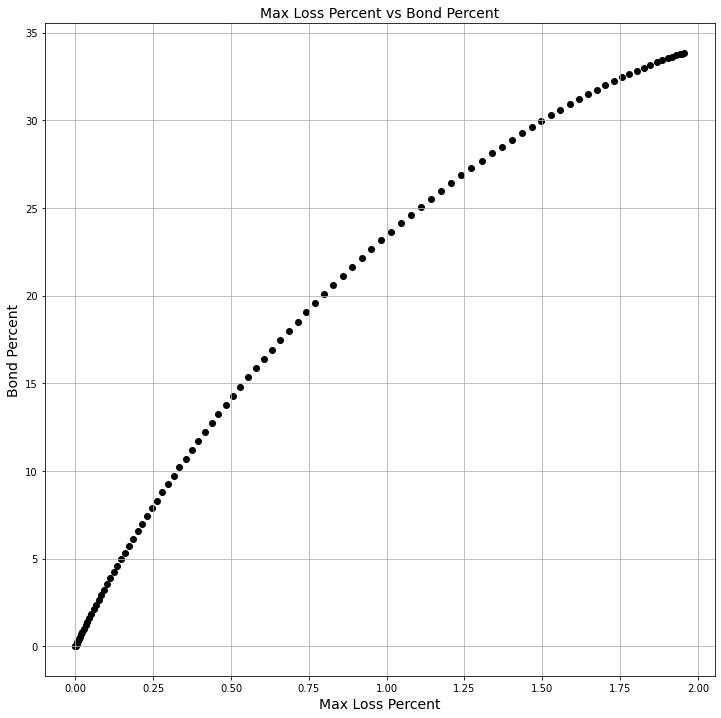

In [126]:
# Plot the raw data output by the sweep
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
plt.grid(True)
plt.title('Max Loss Percent vs Bond Percent', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

In [127]:
# Fit a rational polynomial to the data set.
(num_degree, popt) = ratfit(x, y, x_test, y_test, start_degree=1, end_degree=20, verbose=verbose)
f_approx = lambda x: np.piecewise(x, [x <= max_max_loss_percentage, x > max_max_loss_percentage], [lambda y: ratobj(num_degree)(y, *popt), lambda _: max_bond_percentage])

In [128]:
# Calculate the error averages and extrema
error = y_test - f_approx(x_test)
print(f"median error = {np.median(error):.20f}")
print(f"average error = {np.average(error):.20f}")
print(f"min error = {np.amin(error):.20f}")
print(f"max error = {np.amax(error):.20f}")

median error = 0.00000742195415406877
average error = 0.00000528524067634711
min error = -0.00054517626293204557
max error = 0.00044282898000558291


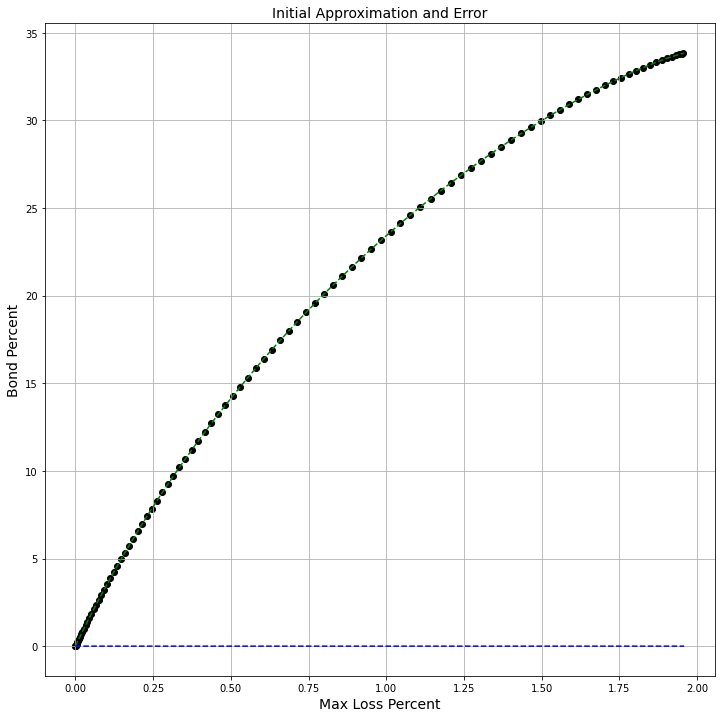

In [129]:
# Plot the Chebyshev approximation against the raw data
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
plt.grid(True)
plt.title('Initial Approximation and Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

plt.plot(x_test, f_approx(x_test), '--', color="green")
plt.plot(x_test, y_test - f_approx(x_test), '--', color="blue")

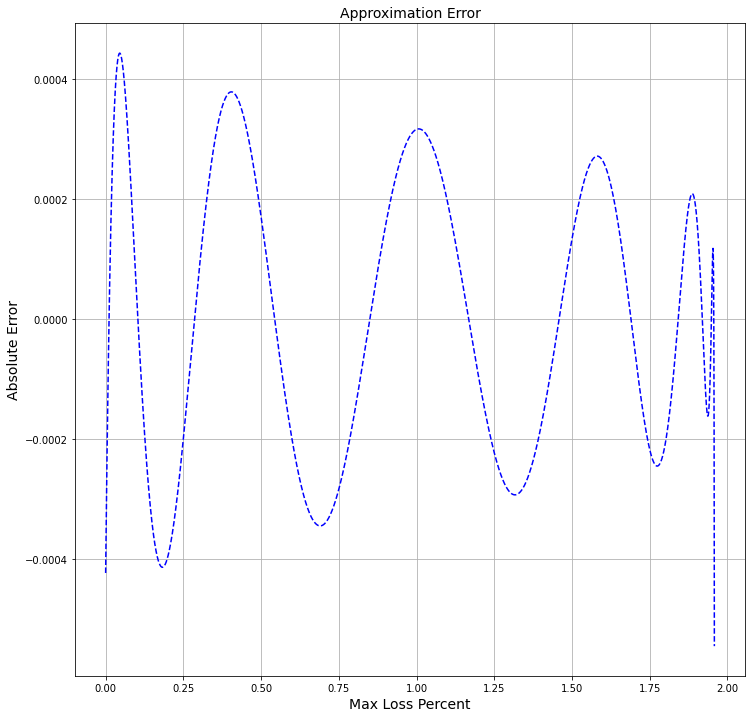

In [130]:
# Plot the absolute error from the approximation
plt.subplots(figsize=(12,12))
plt.grid(True)
plt.title('Approximation Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)

plt.plot(x_test, y_test - f_approx(x_test), '--', color="blue")

In [ ]:
# Sweep over a large range of APRs to compute the approximations.
for apr in np.delete(np.arange(0, 1, 0.1), 0):
    # Calculate the stretched time.
    t_stretch = calc_time_stretch(apr)
    tau = stretch_time(t, t_stretch)

    # Calculate the maximum bond percentage that doesn't result in an invalid max loss.
    (max_max_loss_percentage, max_bond_percentage) = calc_max_loss_endpoints(z, apr, c, mu, phi, t, tau)
 
    # Capture an array of max losses (the x component) and the bond ratios (the y component) 
    # that require the max losses.
    y = calc_chebyshev_nodes(0, max_bond_percentage, 100)
    x = (calc_max_loss_from_apr(z, 0.01 * y, apr, c, mu, phi, t, tau) / z) * 100

    # Construct a new trace of sample data to test for the error
    y_test = np.delete(np.arange(0, max_bond_percentage, 0.001), 0)
    x_test = (calc_max_loss_from_apr(z, 0.01 * y_test, apr, c, mu, phi, t, tau) / z) * 100

    # Fit a rational curve to the data points.
    (num_degree, popt) = ratfit(x, y, x_test, y_test, start_degree=1, end_degree=20, verbose=verbose)
    f_approx = lambda x: np.piecewise(x, [x <= max_max_loss_percentage, x > max_max_loss_percentage], [lambda y: ratobj(num_degree)(y, *popt), lambda _: max_bond_percentage])
    
    # Dump the pickled rational function in a file.
    with open(curves_path, "ab") as f:
        dill.dump(((apr), f_approx), f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
# Load all of the pickled functions into a dictionary keyed by their apr.
f_approxs = {}
with open(curves_path, "rb") as f: 
    while True:
        try:
            (key, f_approx) = dill.load(f)
            f_approxs[key] = f_approx
        except EOFError:
            break